In [1]:
import lucem_illud_2020 as lucem
import pandas as pd
from pandas.plotting import table
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
import seaborn
import sklearn
import spacy
import graphviz
import os.path
import wordcloud
import nltk
import gensim
import rope
from dit import Distribution
from dit.divergences import jensen_shannon_divergence


In [2]:
# load data
days = pd.read_csv(r'.\Classified\all.csv')
days = days.reset_index().drop(['index','Unnamed: 0'], axis=1)
days.shape

(335299, 22)

We've classified our sample of 335299 tweets assigning each account a complete automation probability (CAP), using the Botometer API. 

In [91]:
#%% get unique accounts
accounts = days.drop_duplicates('user_id')
accounts.shape

(82298, 25)

The CAP ranges from 0 to 1. A histogram of CAP values in our sample can help us determine the appropiate cutoff point that distinguishes between bot and user accounts.

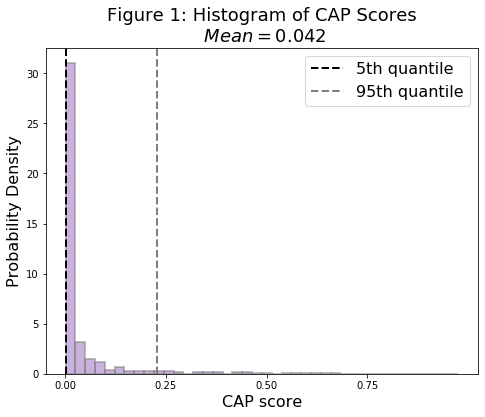

In [97]:
#%% get quantiles
quant_5 = accounts['cap'].quantile(.05)
quant_95 = accounts['cap'].quantile(.95)

#%% create a histogram of caps
num_bins = 40
mu_cap = accounts['cap'].mean()
plt.figure( figsize=(8,6))
n, bins, patches = plt.hist(accounts['cap'], 
                            num_bins, 
                            density=1, 
                            facecolor='tab:purple', 
                            alpha=0.5,
                            edgecolor='grey',
                            linewidth=2)
plt.axvline(quant_5,ymin=0,ymax=1,linestyle='dashed', c='black',
            linewidth=2, label='5th quantile')
plt.axvline(quant_95,ymin=0,ymax=1,linestyle='dashed',c='tab:grey',
            linewidth=2, label='95th quantile')
plt.xticks(np.arange(0, 1, .25))
plt.xlabel('CAP score',
           fontsize=16)
plt.ylabel('Probability Density',
           fontsize=16)
plt.title('Figure 1: Histogram of CAP Scores\n $Mean=0.042$',
          fontsize=18)
plt.legend(loc='best', prop={'size':16})
plt.subplots_adjust(left=0.15)
plt.savefig('hist_CAP.png', format = 'png', bbox_inches='tight')

It looks like the majority of our sample consists of accounts with very low CAP probabilities. This is due to the fact that the Botomoter algorithm is designed to minimize false positives. Choosing a threshold of .50 might be too conservative, and different use cases of the algorithm have determined the appropiate threshold to minimize the missclassification error rate to be around 0.43. This threshold is specific to the sample so it can't be directly extrapolated to our scenario. In this case, it might be best to simply compare the top 5 percent of the CAP distribution against the bottom 5 percent, and make adjustments as we examine the data. Five percent (5%) is a reasonable quantile to pick given other research pointing to up to XYZ number of bot accounts on Twitter - making this a conservative threshold. This implies that every account above 95th quantile of the CAP distribution is a bot.

In [3]:
#create labels for bot accounts above the 95th quantile
days['type'] = ['bot' if x > .43 else "user" for x in days['cap']]
days['type_n'] = [1 if x > .43 else 0 for x in days['cap']]

In [4]:
#filter the bot content
bots = days[days['type']=='bot']

# filter the user content
users = days[days['type']=='user']

In [7]:
#find the number of posts by user vs. nunmber of posts by bot
bot_post_user = pd.DataFrame(days['type'].value_counts()).reset_index()
bot_post_user = bot_post_user.rename(columns={"index":"Account Type",
                                          "type":"# of Posts"})
bot_post_user

,Account Type,# of Posts
0,user,321269
1,bot,14030


In [8]:
#number of bots vs users
bot_num_user = days.drop_duplicates(subset='user_id')['type'].value_counts()
bot_num_user = pd.DataFrame(bot_num_user).reset_index()
bot_num_user = bot_num_user.rename(columns={"index":"Account Type",
                                          "type":"# of Accounts"})
bot_num_user

,Account Type,# of Accounts
0,user,80561
1,bot,1737


In [9]:
#calculate...
#proportion of bot  and user accounts in sample
bot_proportion = days.drop_duplicates(subset='user_id')['type_n'].mean()
user_proportion = 1-bot_proportion
#proportion of posts from bot and user accounts in sample
bot_post_proportion = np.mean(days['type_n'])
user_post_proportion = 1-bot_post_proportion
#proportion of retweets by users and bots
prop_retweets_bot = days[days['is_retweet']==True]['type_n'].mean()
prop_retweets_user = 1 - prop_retweets_bot
#number of retweets by users and bots
num_retweets = days.groupby(['type'])['is_retweet'].sum()
#proportion of tweets by users and bots
prop_tweets_bot = days[days['is_retweet']==False]['type_n'].mean()
prop_tweets_user = 1 - prop_tweets_bot
#number of tweets by user and bots
num_tweets_bot = days[days['is_retweet']==False]['type_n'].sum()
num_tweets_user = days[days['is_retweet']==False]['type_n'].count() - num_tweets_bot

print(bot_proportion,user_proportion,bot_post_proportion,
     user_post_proportion,prop_retweets_user,num_retweets,
     prop_tweets_bot,prop_tweets_user, num_tweets_bot,num_tweets_user)

0.021106223723541276 0.9788937762764587 0.0418432503526703 0.9581567496473297 0.9524573685788351 type
bot      13480.0
user    270055.0
Name: is_retweet, dtype: float64 0.010625144888339386 0.9893748551116606 550 51214


In [10]:
#combine all estimates into a dataframe, starting with number of accounts by type
bot_vs_user = bot_num_user
#add the number of accounts as a percentage
bot_vs_user['# of Accounts (Percent)'] = [round(user_proportion,3),
                                           round(bot_proportion,3)]
bot_vs_user['# of Accounts (Percent)'] = bot_vs_user['# of Accounts (Percent)'].mul(100)
bot_vs_user['# of Accounts (Percent)'] = bot_vs_user['# of Accounts (Percent)'].round(3).astype(str).add('%')
#merge the number of posts by type of account
bot_vs_user = pd.merge(bot_vs_user,bot_post_user,how='left',on='Account Type')
#add the number of posts as a percentage
bot_vs_user['# of Posts (Percent)'] = [round(user_post_proportion,3),
                                         round(bot_post_proportion,3)]
bot_vs_user['# of Posts (Percent)'] = bot_vs_user['# of Posts (Percent)'].mul(100).astype(str).add('%')
#add the number of tweets
bot_vs_user['# of Tweets']=[num_tweets_user, num_tweets_bot]
#add the number of tweets as a percentage
bot_vs_user['# of Tweets (Percent)']=[prop_tweets_user,prop_tweets_bot]
bot_vs_user['# of Tweets (Percent)']= bot_vs_user['# of Tweets (Percent)'].mul(100).round(1).astype(str).add('%')
#add the number of retweets
bot_vs_user['# of Retweets']=[num_retweets[1], num_retweets[0]]
#add the number of retweets as a percentage
bot_vs_user['# of Retweets (Percent)']=[prop_retweets_user,prop_retweets_bot]
bot_vs_user['# of Retweets (Percent)']= bot_vs_user['# of Retweets (Percent)'].mul(100).round(1).astype(str).add('%')


In [11]:
#average number of posts comparison
avg_posts = days.groupby(['user_id','type'])['type'].count().groupby('type').mean()
bot_vs_user["Average Posts (Per Account)"] = [round(avg_posts[1],2),
                                                round(avg_posts[0],2)]

#average number of retweets comparison
avg_retweets = days.groupby(['user_id','type'])['is_retweet'].sum().groupby('type').mean()

#average number of tweets comparison
avg_tweets = avg_posts - avg_retweets

#add values to dataframe
bot_vs_user["Average Tweets (Per Account)"]=[round(avg_tweets[1],2),
                                                round(avg_tweets[0],2)]
bot_vs_user["Average Retweets (Per Account)"]=[round(avg_retweets[1],2),
                                                round(avg_retweets[0],2)]

In [12]:
bot_vs_user = bot_vs_user.T
bot_vs_user.columns = bot_vs_user.iloc[0]
bot_vs_user = bot_vs_user[bot_vs_user['user']!='user']

In [13]:
bot_vs_user

Account Type,user,bot
# of Accounts,80561,1737
# of Accounts (Percent),97.9%,2.1%
# of Posts,321269,14030
# of Posts (Percent),95.8%,4.2%
# of Tweets,51214,550
# of Tweets (Percent),98.9%,1.1%
# of Retweets,270055,13480
# of Retweets (Percent),95.2%,4.8%
Average Posts (Per Account),3.97,6.78
Average Tweets (Per Account),0.63,0.27


The above table shows how even though only a small part of the accounts on Twitter are bots (4.8%), these accounts are responsible for more than 9% of the overall content. These accounts are also highly active in terms of retweets (6.37 per account, on average), compared to original tweets (0.27 per account, on average). 

In [14]:
#examine the network of bot accounts
bot_connect = bots.drop_duplicates(subset='user_id').agg({'friends_count':['mean',
                                                                           'median',
                                                                           'min',
                                                                           'max',
                                                                           'sum'],
                                                          'followers_count':['mean',
                                                                             'median',
                                                                             'min',
                                                                             'max',
                                                                             'sum'],
                                                          'statuses_count':[ 'mean',
                                                                             'median',
                                                                             'min',
                                                                             'max',
                                                                             'sum']})

#add results to dataframe
bot_connect = bot_connect.rename(columns={'friends_count':'# of Friends',
                                          'followers_count':'# of Followers',
                                          'statuses_count':'# of Statuses'})
bot_connect.iloc[3,:]=bot_connect.iloc[3,:].apply(lambda x: '{:.0f}'.format(x))
bot_connect.iloc[4,:]=bot_connect.iloc[4,:].apply(lambda x: '{:.0f}'.format(x))

bot_connect

,# of Friends,# of Followers,# of Statuses
mean,8834.81,9210.96,64815.9
median,1334,785,25800
min,0,0,1
max,154475,154773,868867
sum,18279218,19057473,134104159


In [15]:
#examine the network of user accounts
user_connect = users.drop_duplicates(subset='user_id').agg({'friends_count':['mean',
                                                                             'median',
                                                                             'min',
                                                                             'max',
                                                                             'sum'],
                                                           'followers_count':['mean',
                                                                              'median',
                                                                              'min',
                                                                              'max',
                                                                              'sum'],
                                                           'statuses_count':[ 'mean',
                                                                              'median',
                                                                              'min',
                                                                              'max',
                                                                              'sum']})
#add results to dataframe
user_connect = user_connect.rename(columns={'friends_count':'# of Friends',
                                            'followers_count':'# of Followers',
                                            'statuses_count':'# of Statuses'})

user_connect.iloc[3,:]=user_connect.iloc[3,:].apply(lambda x: '{:.0f}'.format(x))
user_connect.iloc[4,:]=user_connect.iloc[4,:].apply(lambda x: '{:.0f}'.format(x))

user_connect

,# of Friends,# of Followers,# of Statuses
mean,2893.68,5786.04,45558.8
median,851,508,16990
min,0,0,1
max,607024,47921417,2542380
sum,233904458,467702984,3682655041


In [16]:
print(bot_connect)
print("")
print(user_connect)

       # of Friends # of Followers # of Statuses
mean        8834.81        9210.96       64815.9
median         1334            785         25800
min               0              0             1
max          154475         154773        868867
sum        18279218       19057473     134104159

       # of Friends # of Followers # of Statuses
mean        2893.68        5786.04       45558.8
median          851            508         16990
min               0              0             1
max          607024       47921417       2542380
sum       233904458      467702984    3682655041


On average, the above table suggest that bots have a significantly larger network than users, with a higher average number of followers (8063 vs. 2789), friends (8063 vs. 2789) and number of statuses posted (69K vs. 45K). These results are very interesting, given one would expect bot accounts to have a very different type of network than real user accounts. Study X Y and Z have shown that.... The clue as to why we might be seeing this results can be found in the max statuses of both tables. There are various types of automated accounts on Twitter, such as customer service bots for brands, automated news aggregators which specialize on posting news content, there's also automated accounts belonging to news sites which share the outlets content on a continous basis. Unfortunately, the Botometer classifier doesn't distinguish between these various types of accounts. This analysis is not interested in any of these use cases for bot accounts. The focus of this research is on bot accounts that make an active effort to pretend to be real users.

To filter benign bot accounts from our bot sample we will use their follower / friend ratio. Several studies have shown that amplification bots have a hard time mimicking the organic networks that real users have organically - due to their interpersonal connections in the physical world. The follower / friend ratio provides a metric by which to identify the deficiency bot accounts exhibit when trying to replicate these networks.

In [17]:
#%% get following friend ratio
accounts['followers_count'] = accounts['followers_count'] + 1
accounts['friends_count'] = accounts['friends_count'] + 1
accounts['network_ratio'] = accounts['followers_count'] / accounts['friends_count']

C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

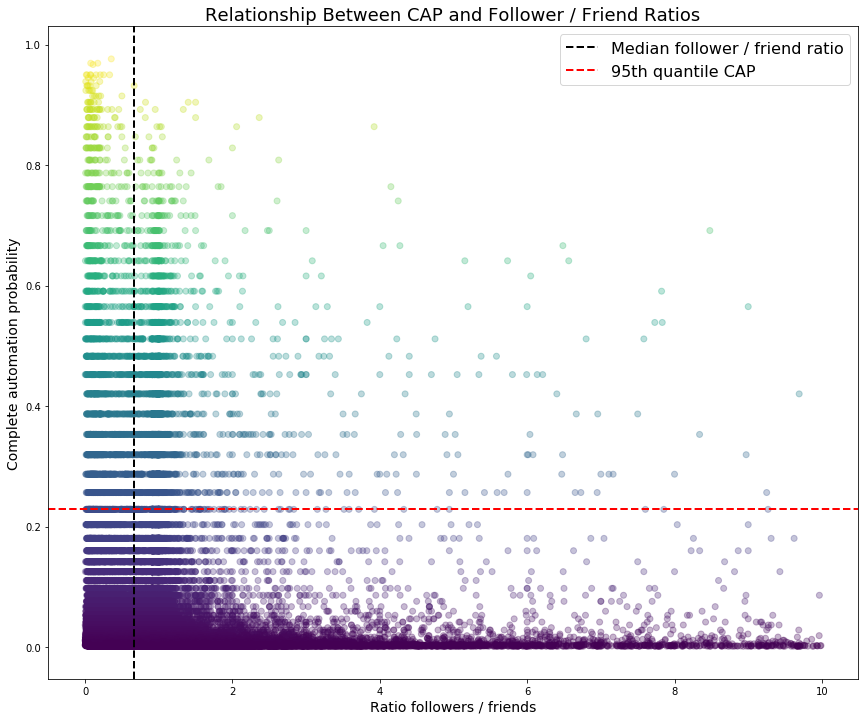

In [18]:
#%% create a histogram of ratio followers to friends

mu_ratio = accounts['network_ratio'].mean()
median_ratio = accounts['network_ratio'].median()
plt.figure( figsize=(15,12))
plt.scatter(accounts[accounts['network_ratio']<10]['network_ratio'],
            accounts[accounts['network_ratio']<10]['cap'],
            c=accounts[accounts['network_ratio']<10]['cap'],
            alpha=0.3)
plt.axvline(median_ratio,ymin=0,ymax=1,linestyle='dashed', c='black',
            linewidth=2, label='Median follower / friend ratio')
plt.axhline(quant_95,linestyle='dashed', c= 'red',
            linewidth=2, label='95th quantile CAP')
plt.xlabel('Ratio followers / friends',
           fontsize=14)
plt.ylabel('Complete automation probability',
           fontsize=14)
plt.title('Relationship Between CAP and Follower / Friend Ratios',
          fontsize=18)
plt.legend(loc='best', prop={'size':16})
plt.subplots_adjust(left=0.15)
plt.savefig('follower_friend_ratio_sub10.png', format = 'png', bbox_inches='tight')


In [13]:
#%% get following friend ratio
bots['followers_count'] = bots['followers_count'] + 1
bots['friends_count'] = bots['friends_count'] + 1
bots['network_ratio'] = bots['followers_count'] / bots['friends_count']

#filter bot content by followers / friends ratio
fake_users = bots[bots['cap'] > .75]

fake_users.shape

(870, 25)

In [20]:
#examine the network of fake user accounts
fake_connect = fake_users.drop_duplicates(subset='user_id').agg({'friends_count':['mean',
                                                                                  'median',
                                                                                  'min',
                                                                                  'max',
                                                                                  'sum'],
                                                               'followers_count':['mean',
                                                                                  'median',
                                                                                  'min',
                                                                                  'max',
                                                                                  'sum'],
                                                               'statuses_count':[ 'mean',
                                                                                  'median',
                                                                                  'min',
                                                                                  'max',
                                                                                  'sum']})
#add results to dataframe
fake_connect = fake_connect.rename(columns={'friends_count':'# of Friends',
                                            'followers_count':'# of Followers',
                                            'statuses_count':'# of Statuses'})

fake_connect.iloc[3,:]=fake_connect.iloc[3,:].apply(lambda x: '{:.0f}'.format(x))
fake_connect.iloc[4,:]=fake_connect.iloc[4,:].apply(lambda x: '{:.0f}'.format(x))

fake_connect

,# of Friends,# of Followers,# of Statuses
mean,2705.14,2645.42,18164.6
median,112,17,465
min,1,1,1
max,60635,60434,434688
sum,738503,722201,4958943


Now we've reduced the size of the network to what presumably are accounts which have bot-like behavior (a high CAP) and a low follower to friend ratio. Nonetheless, we still have accounts within our sample which have posted up to 63K statuses. Let's see if we can find some interesting differences in activity patterns between our fake and real users, by comparing fake users to real users at the bottom of the CAP distribution.

In [44]:
#create a dataframe of users below the 5th quantile

quant_1 = accounts['cap'].quantile(.01)
low_cap = users[users['cap'] < quant_1]
low_cap.shape

(849, 24)

In [22]:
#examine the network of low CAP accounts
lowcap_connect = low_cap.drop_duplicates(subset='user_id').agg({'friends_count':[ 'mean',
                                                                                  'median',
                                                                                  'min',
                                                                                  'max',
                                                                                  'sum'],
                                                               'followers_count':['mean',
                                                                                  'median',
                                                                                  'min',
                                                                                  'max',
                                                                                  'sum'],
                                                               'statuses_count':[ 'mean',
                                                                                  'median',
                                                                                  'min',
                                                                                  'max',
                                                                                  'sum']})
#add results to dataframe
lowcap_connect = lowcap_connect.rename(columns={'friends_count':'# of Friends',
                                                'followers_count':'# of Followers',
                                                'statuses_count':'# of Statuses'})

lowcap_connect.iloc[3,:]=lowcap_connect.iloc[3,:].apply(lambda x: '{:.0f}'.format(x))
lowcap_connect.iloc[4,:]=lowcap_connect.iloc[4,:].apply(lambda x: '{:.0f}'.format(x))

lowcap_connect

,# of Friends,# of Followers,# of Statuses
mean,870.84,21850.3,33237.5
median,588,542.5,19182.5
min,30,21,399
max,6691,3238862,527742
sum,510312,12804265,19477194


C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


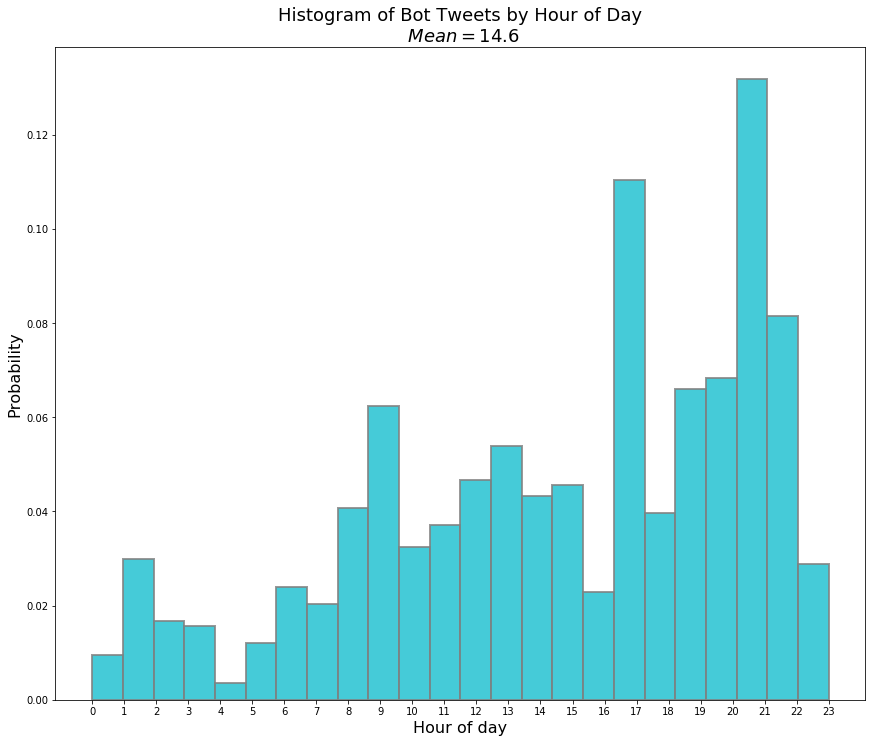

In [23]:
#create an hour column on dataframe to group tweets by hour
fake_users['created_at'] = pd.to_datetime(fake_users['created_at'])
fake_users['hour'] = pd.DatetimeIndex(fake_users.created_at).hour

# plot histogram of hours at which tweets occur
num_bins = 24
mu = fake_users['hour'].mean()
sigma = fake_users['hour'].std()
plt.figure( figsize=(15,12))
n, bins, patches = plt.hist(fake_users['hour'], 
                            num_bins, 
                            density=1, 
                            facecolor='tab:cyan', 
                            alpha=.8,
                            edgecolor='grey',
                            linewidth=2)
plt.xticks(np.arange(min(fake_users['hour']), max(fake_users['hour'])+1, 1.0))
plt.xlabel('Hour of day',
          fontsize=16)
plt.ylabel('Probability',
          fontsize=16)
plt.title('Histogram of Bot Tweets by Hour of Day\n $Mean=14.6$',
         fontsize=18)
plt.subplots_adjust(left=0.15)
plt.savefig('hist_bot_hours.png', format = 'png', bbox_inches='tight')

C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


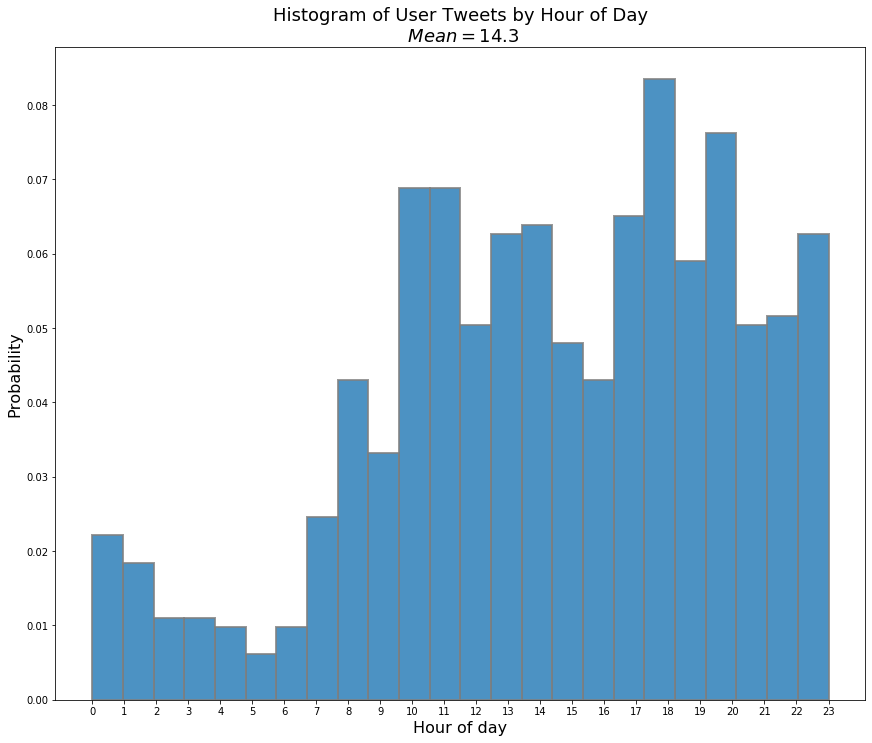

In [24]:
#create an hour column on dataframe to group tweets by hour
low_cap['created_at'] = pd.to_datetime(low_cap['created_at'])
low_cap['hour'] = pd.DatetimeIndex(low_cap.created_at).hour

# plot histogram of hours at which tweets occur
num_bins = 24
mu = low_cap['hour'].mean()
plt.figure( figsize=(15,12))
n, bins, patches = plt.hist(low_cap['hour'], 
                            num_bins, 
                            density=1, 
                            facecolor='tab:blue', 
                            alpha=.8,
                            edgecolor='grey',
                            linewidth=2)
plt.xticks(np.arange(min(low_cap['hour']), max(low_cap['hour'])+1, 1.0))
plt.xlabel('Hour of day',
           fontsize=16)
plt.ylabel('Probability',
           fontsize=16)
plt.title('Histogram of User Tweets by Hour of Day\n $Mean=14.3$',
          fontsize=18)
plt.subplots_adjust(left=0.15)
plt.savefig('hist_lowcap_hours.png', format = 'png', bbox_inches='tight')

It is not surprising to see that bots try to mimic user behavior in such a way that matches a real users tweet activity. This allows false amplification accounts to both deliver their narratives at times where a majority of people are active on Twitter, while also resembling a real users patterns of activity making their actions harder to detect.
 
Lets try to find more distinctive patterns by looking at some of the content in the tweets themeselves, starting with hashtags.


In [25]:
#create a function to count hashtags
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

In [26]:
#tokenize hashtags
fake_hash_tokens = pd.DataFrame(fake_users['hashtags'].dropna())
fake_hash_tokens['tokenized'] = fake_hash_tokens['hashtags'].apply(lambda x: lucem.word_tokenize(x))
fake_hash_tokens = [item for sublist in fake_hash_tokens['tokenized'] for item in sublist]

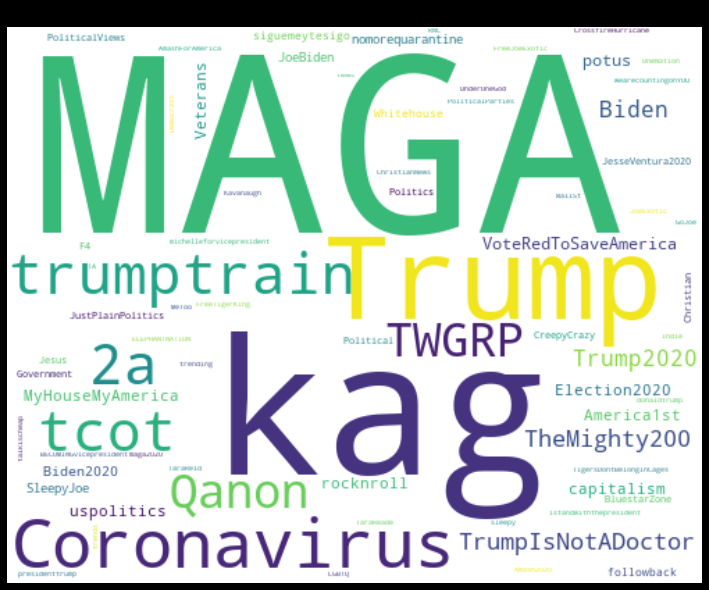

In [27]:
#count hashtags
bot_hash_count = wordCounter(fake_hash_tokens)
bot_hash_count.sort_values('count', ascending=False, inplace=True)

#create wordcloud
bot_hash_wc = wordcloud.WordCloud(background_color="white",
                         max_words=215,
                         width= 1000,
                         height = 800,
                         mode ='RGBA',
                         scale=.5,
                         collocations = False).generate(' '.join(fake_hash_tokens))
plt.figure( figsize=(10,8), facecolor='k')
plt.title('Word Cloud of Hashtags by Fake Users (Bots)',
          fontsize=18)
plt.imshow(bot_hash_wc,interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("bot_hashtags_word_cloud.png", format = 'png', bbox_inches='tight')

In [28]:
#tokenize hashtags for low_cap users
lowcap_hash_tokens = pd.DataFrame(low_cap['hashtags'].dropna())
lowcap_hash_tokens['tokenized'] = lowcap_hash_tokens['hashtags'].apply(lambda x: lucem.word_tokenize(x))
lowcap_hash_tokens = [item for sublist in lowcap_hash_tokens['tokenized'] for item in sublist]

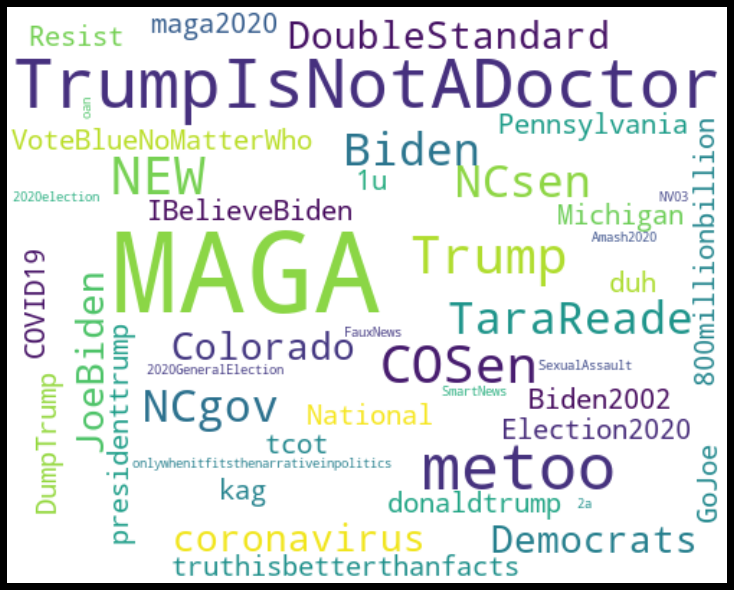

In [29]:
#count hashtags
user_hash_count = wordCounter(lowcap_hash_tokens)
user_hash_count.sort_values('count', ascending=False, inplace=True)

#plot wordcloud
user_hash_wc = wordcloud.WordCloud(background_color="white",
                         max_words=215,
                         width= 1000,
                         height = 800,
                         mode ='RGBA',
                         scale=.5,
                         collocations = False).generate(' '.join(lowcap_hash_tokens))
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(user_hash_wc,interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("user_hashtags_word_cloud.png", format = 'png', bbox_inches='tight')

At a first glance, it looks like hashtags used by fake user accounts are a lot more varied, and the conversation seems to be more evenly distributed among topics. On the contrary, the low-CAP-user conversation seems to be predominantly dominated by a few hashtags, and the majority of these seem to be focused on Trump as opposed to Biden.

Lets perform a similar analysis but now using the actual content of the tweets.

In [30]:
#normalizing text data for fake users
fake_users['tokenized_text'] = fake_users['text'].apply(lambda x: lucem.word_tokenize(x))
fake_users['normalized_text'] = fake_users['tokenized_text'].apply(lambda x: lucem.normalizeTokens(x,
                                                                                                   extra_stop=['>',
                                                                                                               '<',
                                                                                                               'u+0001f1fa><u+0001f1f8',
                                                                                                               'amp'])) 
 
    

C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
#normalizing text data for users
low_cap['tokenized_text'] = low_cap['text'].apply(lambda x: lucem.word_tokenize(x))
low_cap['normalized_text'] = low_cap['tokenized_text'].apply(lambda x: lucem.normalizeTokens(x,
                                                                                             extra_stop=['>',
                                                                                                         '<',
                                                                                                         'u+0001f1fa><u+0001f1f8]',
                                                                                                         'amp']))


C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
#counting top words for bots
fake_countsDict = {}
for word in fake_users['normalized_text'].sum():
    if word in fake_countsDict:
        fake_countsDict[word] += 1
    else:
        fake_countsDict[word] = 1
fake_word_counts = sorted(fake_countsDict.items(), key = lambda x : x[1], reverse = True)

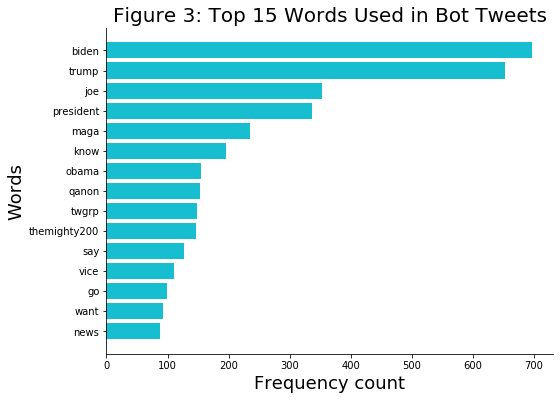

In [33]:
#plotting the top bot words
fake_wordCounts = pd.DataFrame(fake_word_counts,columns=['words','count'])
#bot_wordCounts.to_csv(r'.\Word_counts\bot_wc.csv')
top_botWords = fake_wordCounts.iloc[:15,:]
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top_botWords['words'],top_botWords['count'],
        facecolor='tab:cyan')
ax.set_title('Figure 3: Top 15 Words Used in Bot Tweets',
            fontsize=20)
ax.set_ylabel('Words',
             fontsize=18)
ax.set_xlabel('Frequency count',
             fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("bot_wordcount.png", format = 'png', bbox_inches='tight')

In [34]:
#counting top words for low-CAP users
lowcap_countsDict = {}
for word in low_cap['normalized_text'].sum():
    if word in lowcap_countsDict:
        lowcap_countsDict[word] += 1
    else:
        lowcap_countsDict[word] = 1
lowcap_word_counts = sorted(lowcap_countsDict.items(), key = lambda x : x[1], reverse = True)

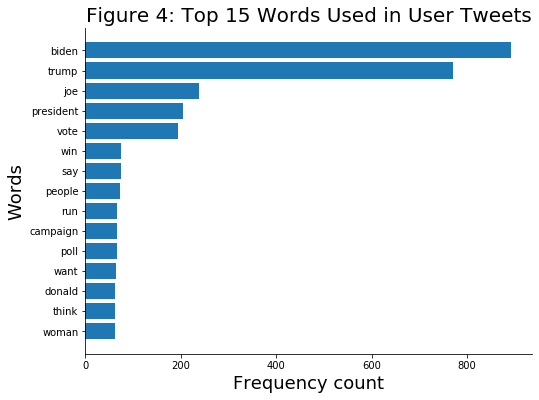

In [35]:
#plotting the top user words
user_wordCounts = pd.DataFrame(lowcap_word_counts,columns=['words','count'])
#user_wordCounts.to_csv(r'.\Word_counts\user_wc.csv')
top_userWords = user_wordCounts.iloc[:15,:]

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top_userWords['words'],top_userWords['count'],
        facecolor='tab:blue')
ax.set_title('Figure 4: Top 15 Words Used in User Tweets',
            fontsize=20)
ax.set_ylabel('Words',
             fontsize=18)
ax.set_xlabel('Frequency count',
             fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("user_wordcount.png", format = 'png', bbox_inches='tight')

This results make it seem like we're comparing exactly the same type of accounts, but let's dig a little deeper to see if we can undercover semantic differences by using bigrams, trigrams and analysis of POS.

In [36]:
#find the top bigrams for bots
botBigrams = nltk.collocations.BigramCollocationFinder.from_words(fake_users['normalized_text'].sum())
bigram_measures = nltk.collocations.BigramAssocMeasures()
bot_top10_bigrams = botBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:10]
bot_top10_bigrams = pd.DataFrame(bot_top10_bigrams, columns=['words','score'])
bot_top10_bigrams['words'] = bot_top10_bigrams['words'].apply(lambda x: x[0] + ' ' + x[1])



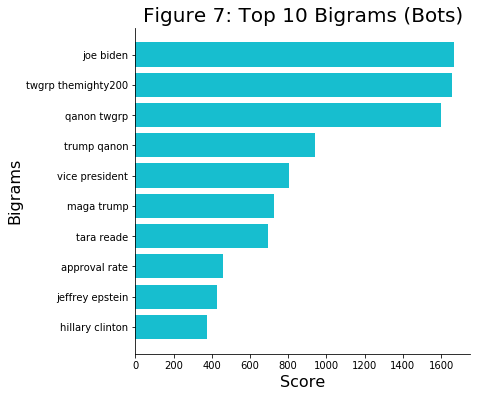

In [45]:
#plotting the top bot words
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(bot_top10_bigrams['words'],bot_top10_bigrams['score'],
        facecolor='tab:cyan')
ax.set_title('Figure 7: Top 10 Bigrams (Bots)',
            fontsize=20)
ax.set_ylabel('Bigrams',
             fontsize=16)
ax.set_xlabel('Score',
             fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("bot_bigrams.png", format = 'png', bbox_inches='tight')

In [43]:
#find the top bigrams for low-cap users
userBigrams = nltk.collocations.BigramCollocationFinder.from_words(low_cap['normalized_text'].sum())
bigram_measures = nltk.collocations.BigramAssocMeasures()
user_top10_bigrams = userBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:10]
user_top10_bigrams = pd.DataFrame(user_top10_bigrams, columns=['words','score'])
user_top10_bigrams['words'] = user_top10_bigrams['words'].apply(lambda x: x[0] + ' ' + x[1])



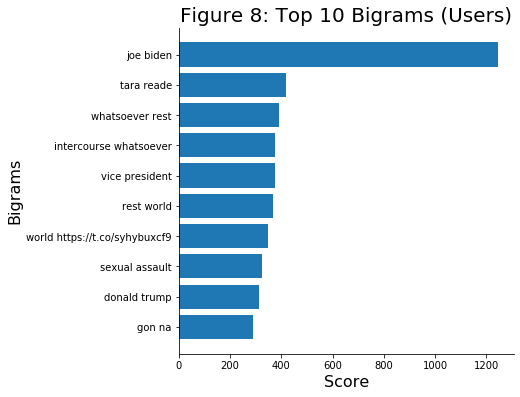

In [46]:
#plotting the top user bigrams
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(user_top10_bigrams['words'],user_top10_bigrams['score'],
        facecolor='tab:blue')
ax.set_title('Figure 8: Top 10 Bigrams (Users)',
            fontsize=20)
ax.set_ylabel('Bigrams',
             fontsize=16)
ax.set_xlabel('Score',
             fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("user_bigrams.png", format = 'png', bbox_inches='tight')

In [48]:
#find the top bigrams for bots
botTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(fake_users['normalized_text'].sum())
trigram_measures = nltk.collocations.TrigramAssocMeasures()
bot_top15_trigrams = botTrigrams.score_ngrams(trigram_measures.likelihood_ratio)[:10]
bot_top15_trigrams = pd.DataFrame(bot_top15_trigrams, columns=['words','score'])
bot_top15_trigrams['words'] = bot_top15_trigrams['words'].apply(lambda x: x[0] + ' ' + x[1]+' '+x[2])


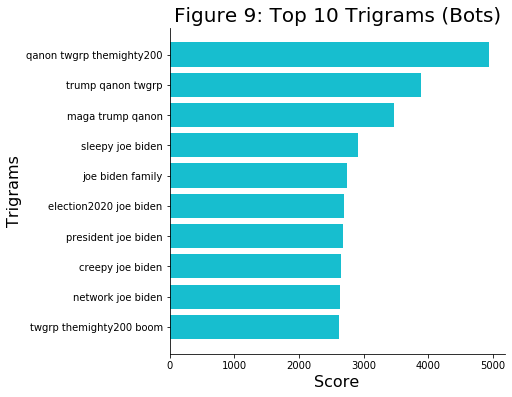

In [51]:
#plotting the top bot words
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(bot_top15_trigrams['words'],bot_top15_trigrams['score'],
        facecolor='tab:cyan')
ax.set_title('Figure 9: Top 10 Trigrams (Bots)',
            fontsize=20)
ax.set_ylabel('Trigrams',
             fontsize=16)
ax.set_xlabel('Score',
             fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("bot_trigrams.png", format = 'png', bbox_inches='tight')

In [52]:
#find the top bigrams for low-cap users
userTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(low_cap['normalized_text'].sum())
trigram_measures = nltk.collocations.TrigramAssocMeasures()
user_top15_trigrams = userTrigrams.score_ngrams(trigram_measures.likelihood_ratio)[:10]
user_top15_trigrams = pd.DataFrame(user_top15_trigrams, columns=['words','score'])
user_top15_trigrams['words'] = user_top15_trigrams['words'].apply(lambda x: x[0] + ' ' + x[1]+' '+x[2])

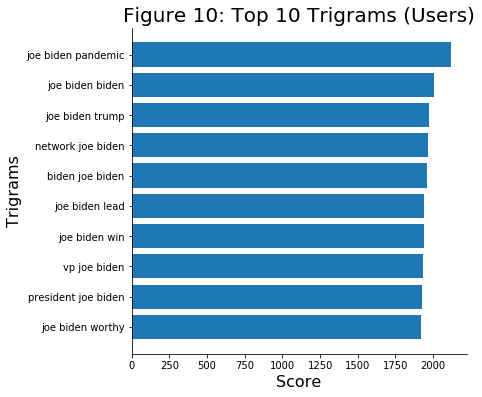

In [54]:
#plotting the top user bigrams
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(user_top15_trigrams['words'],user_top15_trigrams['score'],
        facecolor='tab:blue')
ax.set_title('Figure 10: Top 10 Trigrams (Users)',
            fontsize=20)
ax.set_ylabel('Trigrams',
             fontsize=16)
ax.set_xlabel('Score',
             fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("user_trigrams.png", format = 'png', bbox_inches='tight')

In [55]:
#%% tag the parts of speech for bot content
nlp = spacy.load("en_core_web_sm")
fake_users['sentences'] = fake_users['text'].apply(lambda x: [lucem.word_tokenize(s) for s in lucem.sent_tokenize(x)])
fake_users.index = range(len(fake_users) - 1, -1,-1) #Reindex to make things nice in the future

C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
#%% tag the parts of speech for user content
low_cap['sentences'] = low_cap['text'].apply(lambda x: [lucem.word_tokenize(s) for s in lucem.sent_tokenize(x)])
low_cap.index = range(len(low_cap) - 1, -1,-1) #Reindex to make things nice in the future

C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
#%% define a function to tag parts of speech
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [58]:
#tag the sentences with their parts of speech
fake_users['POS_sents'] = fake_users['sentences'].apply(lambda x: tag_sents_pos(x))

fake_users['POS_sents'].head(3)

C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


869    [[(@washingtonpost, ADD), (I, PRP), (', ``), (...
868    [[(Joe, NNP), (Biden, NNP), (Claims, VBZ), (60...
867    [[(Another, DT), (great, JJ), (ad, NN), (by, I...
Name: POS_sents, dtype: object

In [59]:
#tag the sentences with their parts of speech
low_cap['POS_sents'] = low_cap['sentences'].apply(lambda x: tag_sents_pos(x))

low_cap['POS_sents'].head(3)

C:\Users\pauli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


848    [[(@NightmareAsylum, UH), (@TruthRaiderHQ, NNP...
847    [[(@AriCohn, DT), (@luismen1991, CD), (@gul_ga...
846    [[(Biden, NNP), (is, VBZ), (more, RBR), (Trump...
Name: POS_sents, dtype: object

In [60]:
# define a function to count each POS associated with each word
def pos_counter(data, word, target):
    NTarget = target
    Word = word
    targetCounts = {}
    for entry in data['POS_sents']:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1,ent2.lower())==(NTarget,Word):
                    if ent1 in targetCounts:
                        targetCounts[ent1] += 1
                    else:
                        targetCounts[ent1] = 1
                else:
                    continue
    return targetCounts


In [61]:
#calculate most frequent adjectives used by bots along the word trump
target_counts = pos_counter(fake_users,word='trump',target='JJ')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

trump_jj_bots = pd.DataFrame(sortedTargets, columns=['adjective','count'])
trump_jj_bots.head(10)

,adjective,count
0,Anti,4
1,accurate,2
2,anti,2
3,new,1
4,currupt,1
5,Official,1


In [62]:
#calculate most frequent adjectives used by users along the word trump
target_counts = pos_counter(low_cap,word='trump',target='JJ')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

trump_jj_users = pd.DataFrame(sortedTargets, columns=['adjective','count'])
trump_jj_users.head(10)

,adjective,count
0,pro,5
1,Anti,3
2,Biden,1
3,singular,1
4,@michaelscherer,1
5,same,1
6,@briebriejoy,1
7,wrong,1
8,trade-,1
9,bad,1


In [63]:
#calculate most frequent adjectives used by bots along the word biden
target_counts = pos_counter(fake_users,word='biden',target='JJ')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

biden_jj_bots = pd.DataFrame(sortedTargets, columns=['adjective','count'])
biden_jj_bots.head(10)

,adjective,count
0,enough,7
1,innocent,3
2,fake,2
3,unprepared,2
4,NEW,1
5,Great,1
6,total,1
7,Exclusive,1


In [64]:
#calculate most frequent adjectives used by users along the word biden
target_counts = pos_counter(low_cap,word='biden',target='JJ')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

biden_jj_users = pd.DataFrame(sortedTargets, columns=['adjective','count'])
biden_jj_users.head(10)

,adjective,count
0,becuz,4
1,anti,4
2,sad,2
3,single,2
4,bad,1
5,old,1
6,trump,1
7,Great,1
8,official,1
9,feeble,1


In [65]:
#calculate most frequent verbs used by bots along the word trump
target_counts = pos_counter(fake_users,word='trump',target='VB')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

trump_vb_bots = pd.DataFrame(sortedTargets, columns=['verb','count'])
trump_vb_bots.head(10)

,verb,count
0,target,4
1,Beat,3
2,roast,2
3,hate,2
4,beat,2
5,attack,2
6,blame,1
7,mean,1
8,hear,1
9,fight,1


In [66]:
#calculate most frequent verbs used by users along the word trump
target_counts = pos_counter(low_cap,word='trump',target='VB')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

trump_vb_users = pd.DataFrame(sortedTargets, columns=['verb','count'])
trump_vb_users.head(10)

,verb,count
0,beat,14
1,let,5
2,want,4
3,like,4
4,vote,3
5,think,3
6,make,2
7,defeat,2
8,keep,2
9,stand,2


In [67]:
#calculate most frequent verbs used by bots along the word biden
target_counts = pos_counter(fake_users,word='biden',target='VB')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

biden_vb_bots = pd.DataFrame(sortedTargets, columns=['verbs','count'])
biden_vb_bots.head(10)

,verbs,count
0,be,9
1,attack,4
2,replace,3
3,Become,2
4,give,2
5,bust,2
6,support,1
7,allow,1
8,hate,1
9,want,1


In [68]:
#calculate most frequent adjectives used by users along the word biden
target_counts = pos_counter(low_cap,word='biden',target='VB')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

biden_vb_users = pd.DataFrame(sortedTargets, columns=['verbs','count'])
biden_vb_users.head(10)

,verbs,count
0,attack,7
1,be,4
2,want,3
3,vote,3
4,think,2
5,replace,2
6,push,2
7,discredit,2
8,support,2
9,remove,2


In [69]:
#calculate most frequent nouns used by bots along the word trump
target_counts = pos_counter(fake_users,word='trump',target='NN')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

trump_nn_bots = pd.DataFrame(sortedTargets, columns=['nouns','count'])
trump_nn_bots.head(10)

,nouns,count
0,MAGA,22
1,Time,4
2,scheme,2
3,debate,1
4,SMH2020,1
5,scrutiny,1
6,corruption,1
7,DNA,1
8,way,1
9,movement,1


In [70]:
#calculate most frequent nouns used by users along the word trump
target_counts = pos_counter(low_cap,word='trump',target='NN')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

trump_nn_users = pd.DataFrame(sortedTargets, columns=['nouns','count'])
trump_nn_users.head(10)

,nouns,count
0,candidate,5
1,today,2
2,economy,2
3,security,2
4,policy,2
5,talk,2
6,woman,1
7,community,1
8,pressure,1
9,Vote,1


In [71]:
#calculate most frequent nouns used by bots along the word biden
target_counts = pos_counter(fake_users,word='biden',target='NN')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

biden_nn_bots = pd.DataFrame(sortedTargets, columns=['nouns','count'])
biden_nn_bots.head(10)

,nouns,count
0,economy,7
1,amp,3
2,support,2
3,office,2
4,damn,1
5,poof,1
6,politician,1
7,ticket,1
8,power,1
9,story,1


In [72]:
#calculate most frequent nouns used by users along the word biden
target_counts = pos_counter(low_cap,word='biden',target='NN')

sortedTargets = sorted(target_counts.items(), key = lambda x: x[1], reverse = True)    

biden_nn_users = pd.DataFrame(sortedTargets, columns=['nouns','count'])
biden_nn_users.head(10)

,nouns,count
0,poll,7
1,fact,4
2,Vote,3
3,something,3
4,amp,3
5,epicenter,1
6,case,1
7,comparison,1
8,idiot,1
9,talker,1


If one where to simply look at the top words used by each group (bots vs. users), it would be easy to think that the content was exactly the same. However, by examining the collocations of trigrams and the POS one can clearly see that the bot conversation has a much different tone towards Joe Biden that the real user conversation.

In [73]:
baseline_JS = 0.15495686522757365
baseline_KL1 = 0.1005708155242757
baseline_KL2 = 0.10106802308760038

In [74]:
#calculate the overlap in words and their porbabilities
word_overlap = pd.merge(fake_wordCounts, user_wordCounts, on='words',how='inner')
word_overlap['bot_probs'] = word_overlap['count_x'] / word_overlap['count_x'].sum()
word_overlap['user_probs'] = word_overlap['count_y'] / word_overlap['count_y'].sum()

In [75]:
#transfrm probabilities into array for efficiency
bot_array = np.array(word_overlap['bot_probs'])
user_array = np.array(word_overlap['user_probs'])

In [76]:
#calculate the K-L divergence
bot_KL = scipy.stats.entropy(bot_array, user_array)
user_KL = scipy.stats.entropy(user_array, bot_array)

In [77]:
#calculate the elemtwise KL divergence for bots
word_overlap['bot_kl_divergence']= scipy.special.kl_div(bot_array, user_array)


In [78]:
#sort values
word_overlap = word_overlap.sort_values(by='bot_kl_divergence', ascending=False)

In [79]:
#Calculate the Jensen-Shannon divergence
bot_vs_userJS = scipy.spatial.distance.jensenshannon(bot_array, user_array)
bot_vs_userJS

0.31722896878413814

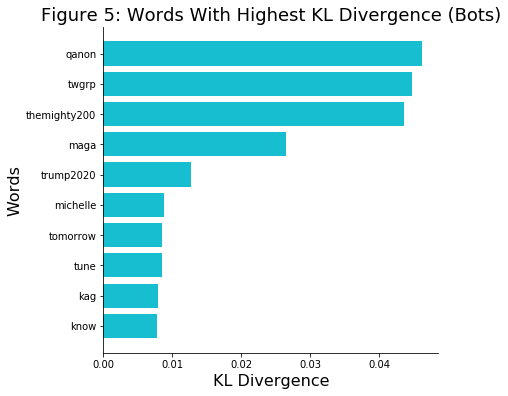

In [82]:
#plot the words from bots with the highest divergence
top10_divergence = word_overlap.iloc[:10,:]
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(top10_divergence['words'],top10_divergence['bot_kl_divergence'],
        facecolor='tab:cyan')
ax.set_title('Figure 5: Words With Highest KL Divergence (Bots)', fontsize=18)
ax.set_ylabel('Words',fontsize=16)
ax.set_xlabel('KL Divergence',fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("bot_divergence.png", format = 'png', bbox_inches='tight')

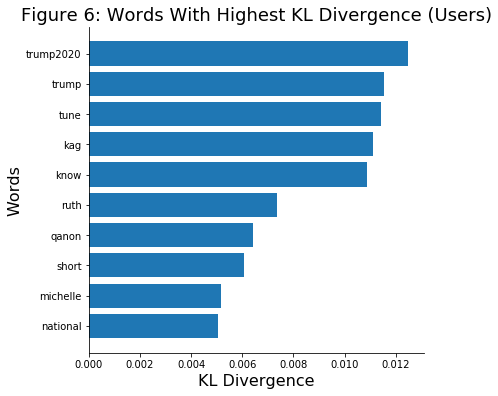

In [83]:
#calculate the elemtwise KL divergence for bots
word_overlap['user_kl_divergence']= scipy.special.kl_div(user_array, bot_array)
word_overlap = word_overlap.sort_values(by='user_kl_divergence', ascending=False)
top10_divergence = word_overlap.iloc[:10,:]

#plot the words from users with the highest divergence
fig, ax = plt.subplots(figsize=(6,6))
ax.barh(top10_divergence['words'],top10_divergence['user_kl_divergence'],
        facecolor='tab:blue')
ax.set_title('Figure 6: Words With Highest KL Divergence (Users)', fontsize=18)
ax.set_ylabel('Words',fontsize=16)
ax.set_xlabel('KL Divergence',fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
plt.savefig("user_divergence.png", format = 'png', bbox_inches='tight')

Now we try to see which topics bots are talking about the most. We trained several LDA models and found that the one with the highest coherence score was that which had 14 topics.

In [310]:
#load the 14 topic lda model
from sklearn.externals import joblib 
lda_14 = joblib.load(r'.\LDA\lda_14.pkl') 

#create a dataframe with the words that best identify each topic
topicsDict = {}
for topicNum in range(lda_14.num_topics):
    topicWords = [w for w, p in lda_14.show_topic(topicNum)]
    topicsDict['Topic {}'.format(topicNum)] = topicWords
wordRanks_14 = pd.DataFrame(topicsDict)
wordRanks_14

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13
0,reade,flynn,poll,know,like,lie,china,win,joe,maga,woman,obama,president,vote
1,tara,campaign,lead,joe,supporter,oval,key,beat,old,trump2020,rape,anti,joe,party
2,sexual,lawyer,joe,president,look,news,pandemic,need,public,kag,accuse,entire,run,bernie
3,assault,russia,drop,obama,people,donor,coronavirus,want,fuck,president,believe,january,say,people
4,allegation,investigation,point,donald,rapist,like,death,lose,talk,qanon,accuser,white,vice,democrat
5,claim,justice,election,people,democrat,fake,country,think,say,wwg1wga,assault,office,obama,want
6,joe,hoax,test,american,thing,barr,america,debate,force,god,ad,house,endorse,win
7,story,record,new,care,hold,bad,response,pick,let,america,question,presidency,office,november
8,accusation,attack,race,corrupt,support,know,americans,amash,year,obama,allegation,administration,step,think
9,false,pay,state,america,try,want,campaign,vp,video,economy,metoo,die,year,voter


In [24]:
topics_df = pd.read_csv(r'.\LDA\topic_labels.csv')
topics_df.drop('Unnamed: 0', axis=1)

,text,max_topic
0,The Lincoln Movement is a fundraising arm of t...,10
1,Biden is Kristol's pro-war candidate of choice...,12
2,The @TheLincolnPAC is a front group for the Jo...,6
3,The Lincoln Movement is a front for Biden-back...,10
4,@TheLincolnPAC The Lincoln Movement is a front...,10
...,...,...
59238,"Top story: Prominent lawyer, Trump donor repre...",5
59239,Biden's edge evaporates as Trump seen as bette...,13
59240,"Prominent lawyer, Trump donor representing Bid...",5
59241,@marxist_morgan people have their blinders on ...,10


In [22]:
# load data
days = pd.read_csv(r'.\Classified\all.csv')
days = days.reset_index().drop(['index','Unnamed: 0'], axis=1)

#create labels for bot accounts above the 95th quantile
days['type'] = ['bot' if x > .43 else "user" for x in days['cap']]
days['type_n'] = [1 if x > .43 else 0 for x in days['cap']]


In [25]:
#add topics to tweets dataframe
days = pd.merge(days, topics_df, on='text', how='outer').drop('Unnamed: 0', axis=1)

In [26]:
days.head(3)

,user_id,status_id,created_at,screen_name,text,is_retweet,favorite_count,retweet_count,hashtags,mentions_screen_name,...,followers_count,friends_count,statuses_count,account_created_at,verified,location,cap,type,type_n,max_topic
0,1.256388e+18,1.256775e+18,2020-05-02 22:38:31,AmashCalifornia,The Lincoln Movement is a fundraising arm of t...,False,4,0,NaN,NaN,...,109,295,410,2020-05-02T00:59:16Z,False,Southern California,0.028226,user,0,10
1,1.256388e+18,1.256775e+18,2020-05-02 22:38:31,AmashCalifornia,The Lincoln Movement is a fundraising arm of t...,False,4,0,NaN,NaN,...,109,295,410,2020-05-02T00:59:16Z,False,Southern California,0.018904,user,0,10
2,1.256388e+18,1.256775e+18,2020-05-02 22:38:31,AmashCalifornia,The Lincoln Movement is a fundraising arm of t...,False,4,0,NaN,NaN,...,109,295,410,2020-05-02T00:59:16Z,False,Southern California,0.028226,user,0,10


In [27]:
#turn topics column into string
days['max_topic'] = days['max_topic'].apply(str)



In [90]:

#calculate number of posts belonging to each topic for the whole set
topic_counts = days.groupby(['max_topic', 'type'])['max_topic'].count()
topic_counts = pd.DataFrame(topic_counts)
topic_counts = topic_counts.rename(columns={'max_topic':'Count'}).reset_index()

#get the proportion of tweets that belong to each topic from each type of account
topic_counts['proportion'] = [topic_counts.iloc[i,2] / bot_post_user.iloc[1,1] 
                              if topic_counts.iloc[i,1] == 'bot' else
                              topic_counts.iloc[i,2] / bot_post_user.iloc[0,1] 
                              for i in range(0,len(topic_counts))]


In [91]:
#turn the proportion into a percent
topic_counts['percent'] = topic_counts.proportion.mul(100).round(2)
topic_counts['max_topic'] = topic_counts['max_topic'].apply(int)
topic_counts.sort_values('max_topic', ascending=True, inplace=True)
topic_counts

,max_topic,type,Count,proportion,percent
0,0,bot,802,0.057163,5.72
1,0,user,26217,0.081605,8.16
2,1,bot,833,0.059373,5.94
3,1,user,17012,0.052953,5.30
12,2,bot,720,0.051319,5.13
13,2,user,26168,0.081452,8.15
14,3,bot,1271,0.090592,9.06
15,3,user,32712,0.101821,10.18
16,4,bot,409,0.029152,2.92
17,4,user,19242,0.059894,5.99


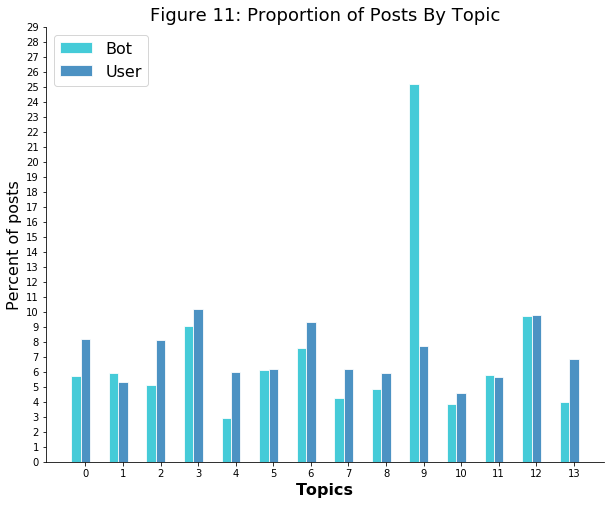

In [93]:
#create a barplot with the percent for each topic
# set width of bar
barWidth = 0.25
 
# set heights of bar
bot = topic_counts[topic_counts['type']=='bot']['percent']
user = topic_counts[topic_counts['type']=='user']['percent']
topics = topic_counts.drop_duplicates(['max_topic'])['max_topic']

# Set position of bar on X axis
r1 = np.arange(len(bot))
r2 = [x + barWidth for x in r1]

#create the figure
fig, ax = plt.subplots(figsize=(10,8))
 
# Make the plot
ax.bar(r1, bot, color='tab:cyan', width=barWidth, edgecolor='white', label='Bot', alpha=0.8)
ax.bar(r2, user, color='tab:blue', width=barWidth, edgecolor='white', label='User', alpha=0.8)

# Add xticks on the middle of the group bars
plt.xlabel('Topics', fontweight='bold', fontsize=16)
plt.ylabel('Percent of posts', fontsize=16)
plt.title('Figure 11: Proportion of Posts By Topic', fontsize=18)
plt.xticks([r + barWidth for r in range(len(bot))], topics)
plt.yticks(np.arange(0,30))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
# Create legend & Show graphic
plt.legend(loc='upper left', fontsize=16)
plt.savefig("percent_topics.png", format = 'png', bbox_inches='tight')


In [61]:
#load influence data
three_hour = pd.read_csv(r'.\Scores\three_hour.csv').drop(['Unnamed: 0'], axis=1)
twenty_minute = pd.read_csv(r'.\Scores\five_min.csv').drop(['Unnamed: 0'], axis=1)


In [62]:
three_hour = three_hour[['status_id', 'novelty','transience','resonance']]
three_hour = three_hour.rename(columns={'novelty':'nov_3hour', 'transience':'trans_3hour','resonance':'res_3hour'})
twenty_minute = twenty_minute[['status_id', 'novelty','transience','resonance']]
twenty_minute = twenty_minute.rename(columns={'novelty':'nov_20min', 'transience':'trans_20min','resonance':'res_20min'})

scores = pd.merge(three_hour,twenty_minute,on="status_id",how='outer')

In [65]:
#filter bot content for those with high CAP
fake_users = days[days['cap'] > .75]
fake_users = pd.merge(fake_users,scores,on="status_id",how='left')
fake_users.shape


(884, 31)

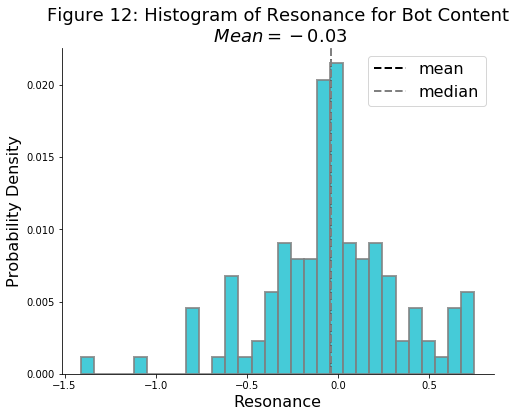

In [129]:
# plot histogram of hours at which tweets occur
num_bins = 30
mu = fake_users['res_3hour'].mean()
median = fake_users['res_3hour'].median()
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = plt.hist(fake_users['res_3hour'], 
                            num_bins, 
                            weights=np.ones(len(fake_users['res_3hour'])) / len(fake_users['res_3hour']), 
                            facecolor='tab:cyan', 
                            alpha=.8,
                            edgecolor='grey',
                            linewidth=2)
plt.axvline(mu,ymin=0,ymax=1,linestyle='dashed', c='black',
            linewidth=2, label='mean')
plt.axvline(median,ymin=0,ymax=1,linestyle='dashed', c='grey',
            linewidth=2, label='median')
plt.xlabel('Resonance',
          fontsize=16)
plt.ylabel('Probability Density',
          fontsize=16)
plt.title('Figure 12: Histogram of Resonance for Bot Content\n $Mean=-0.03$',
         fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0.15)
plt.legend(loc='best', fontsize=16)
plt.savefig('hist_bot_resonance.png', format = 'png', bbox_inches='tight')

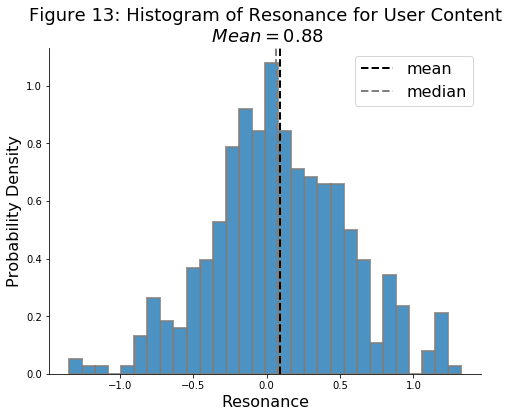

In [128]:
# plot histogram of hours at which tweets occur
num_bins = 30
mu = low_cap['res_3hour'].mean()
median = low_cap['res_3hour'].median()
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = plt.hist(low_cap['res_3hour'], 
                            num_bins, 
                            density=True, 
                            facecolor='tab:blue',
                            edgecolor='grey',
                            alpha=.8,
                            linewidth=2)
plt.axvline(mu,ymin=0,ymax=1,linestyle='dashed', c='black',
            linewidth=2, label='mean')
plt.axvline(median,ymin=0,ymax=1,linestyle='dashed', c='grey',
            linewidth=2, label='median')
plt.xlabel('Resonance',
          fontsize=16)
plt.ylabel('Probability Density',
          fontsize=16)
plt.title('Figure 13: Histogram of Resonance for User Content\n $Mean=0.88$',
         fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0.15)
plt.legend(loc='best', fontsize=16)
plt.savefig('hist_user_resonance.png', format = 'png', bbox_inches='tight')

In [112]:
mu

0.08815000728509105

In [66]:
#filter user content for those with high CAP
low_cap = days[days['cap'] < quant_1]
low_cap = pd.merge(low_cap,scores,on="status_id",how='left')
low_cap.shape

(935, 31)

In [67]:
comparison_group = pd.concat([fake_users,low_cap])
comparison_group['max_topic'].head(5)

0    11
1     8
2     6
3     6
4     6
Name: max_topic, dtype: object

In [68]:
comparison_group.sort_values('res_3hour', ascending=False, inplace=True)


In [69]:
comparison_group.shape

(1819, 31)

In [70]:
comparison_group[comparison_group['type']=='bot'].count()

user_id                    884
status_id                  884
created_at                 884
screen_name                884
text                       884
is_retweet                 884
favorite_count             884
retweet_count              884
hashtags                   194
mentions_screen_name       782
retweet_favorite_count     752
retweet_followers_count    752
retweet_friends_count      752
retweet_verified           752
description                714
followers_count            884
friends_count              884
statuses_count             884
account_created_at         884
verified                   884
location                   463
cap                        884
type                       884
type_n                     884
max_topic                  884
nov_3hour                  127
trans_3hour                127
res_3hour                  127
nov_20min                  157
trans_20min                157
res_20min                  157
dtype: int64

In [71]:
#calculate number of posts belonging to each topic for the whole set
mean_res = comparison_group.groupby(['max_topic', 'type'])['res_3hour'].mean()
mean_res = pd.DataFrame(mean_res)
mean_res = mean_res.rename(columns={'res_3hour':'Resonance'}).reset_index()
mean_res['max_topic'] = mean_res['max_topic'].apply(int)
mean_res.sort_values('max_topic', ascending=True, inplace=True)
mean_res

,max_topic,type,Resonance
0,0,bot,0.111344
1,0,user,-0.049515
2,1,bot,0.005489
3,1,user,-0.087736
12,2,bot,0.044936
13,2,user,0.119140
14,3,bot,0.104921
15,3,user,0.034120
16,4,bot,0.250805
17,4,user,-0.058898


In [72]:
#calculate the max influence for each topic
max_res = comparison_group.groupby(['max_topic', 'type'])['res_3hour'].max()
max_res = pd.DataFrame(max_res)
max_res = max_res.rename(columns={'res_3hour':'Max_Resonance'}).reset_index()
max_res['max_topic'] = max_res['max_topic'].apply(int)
max_res.sort_values('max_topic', ascending=True, inplace=True)

In [73]:
max_res

,max_topic,type,Max_Resonance
0,0,bot,0.388018
1,0,user,0.582769
2,1,bot,0.167525
3,1,user,0.788376
12,2,bot,0.364775
13,2,user,0.454760
14,3,bot,0.710840
15,3,user,0.671375
16,4,bot,0.578815
17,4,user,0.737446


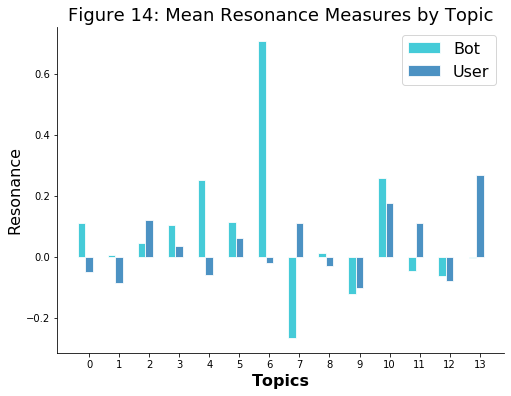

In [126]:
#create a barplot with the percent for each topic
# set width of bar
barWidth = 0.25
 
# set heights of bar and max points
bot = mean_res[mean_res['type']=='bot']['Resonance']
user = mean_res[mean_res['type']=='user']['Resonance']
topics = mean_res.drop_duplicates(['max_topic'])['max_topic']

# Set position of bar on X axis
r1 = np.arange(len(bot))
r2 = [x + barWidth for x in r1]

#create the figure
fig, ax = plt.subplots(figsize=(8,6))
 
# Make the plot
ax.bar(r1, bot, color='tab:cyan', width=barWidth, edgecolor='white', label='Bot', alpha=0.8)
ax.bar(r2, user, color='tab:blue', width=barWidth, edgecolor='white', label='User', alpha=0.8)

# Add xticks on the middle of the group bars
plt.xlabel('Topics', fontweight='bold', fontsize=16)
plt.ylabel('Resonance', fontsize=16)
plt.title('Figure 14: Mean Resonance Measures by Topic', fontsize=18)
plt.xticks([r + barWidth for r in range(len(bot))], topics)
#plt.yticks(np.arange(0,30))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
# Create legend & save graphic
plt.legend(loc='best', fontsize=16)
plt.savefig("resonance_measures.png", format = 'png', bbox_inches='tight')

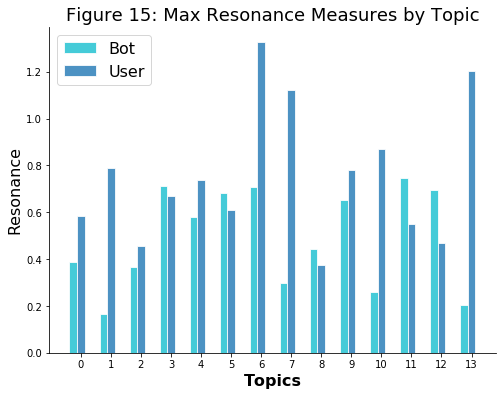

In [127]:
#create a barplot with the percent for each topic
# set width of bar
barWidth = 0.25
 
# set heights of bar and max points
max_bot = max_res[max_res['type']=='bot']['Max_Resonance']
max_user = max_res[max_res['type']=='user']['Max_Resonance']
topics = mean_res.drop_duplicates(['max_topic'])['max_topic']

# Set position of bar on X axis
r1 = np.arange(len(max_bot))
r2 = [x + barWidth for x in r1]

#create the figure
fig, ax = plt.subplots(figsize=(8,6))
 
# Make the plot
ax.bar(r1, max_bot, color='tab:cyan', width=barWidth, edgecolor='white', label='Bot', alpha=0.8)
ax.bar(r2, max_user, color='tab:blue', width=barWidth, edgecolor='white', label='User', alpha=0.8)

# Add xticks on the middle of the group bars
plt.xlabel('Topics', fontweight='bold', fontsize=16)
plt.ylabel('Resonance', fontsize=16)
plt.title('Figure 15: Max Resonance Measures by Topic', fontsize=18)
plt.xticks([r + barWidth for r in range(len(bot))], topics)
#plt.yticks(np.arange(0,30))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
# Create legend & Show graphic
plt.legend(loc='best', fontsize=16)
plt.savefig("resonance_measures.png", format = 'png', bbox_inches='tight')

In [5]:
#days = pd.read_csv(r'.\Full_data\tweets.csv')  #.to_csv(r'.\Full_data\tweets.csv')

C:\Users\pauli\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
#tweets = days[['text','followers_count','friends_count','favorite_count','retweet_count','type','res_20min','res_3hour']]
#tweets= tweets[tweets['res_3hour'].notna()]

In [ ]:
#bot_inf = days[]

In [478]:
#x = tweets[['followers_count','friends_count','favorite_count','retweet_count']].values
#y = tweets['res_3hour'].values

In [479]:
#from sklearn.linear_model import LinearRegression
#from sklearn import metrics
#regressor = LinearRegression()  
#regressor.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [480]:
#x

array([[ 54, 437,   0,   0],
       [ 35, 220,   0,   0],
       [518, 248,   0,   0],
       ...,
       [ 97, 174,   0,   0],
       [ 97, 174,   0,   0],
       [  0,  20,   0,   0]], dtype=int64)

In [482]:
#coeff_df = pd.DataFrame(regressor.coef_, index=[['followers_count','friends_count','favorite_count','retweet_count']],
                        columns=['Coefficient'])  
#coeff_df

,Coefficient
followers_count,3.541727e-09
friends_count,-1.542181e-07
favorite_count,2.278801e-05
retweet_count,-6.174252e-05


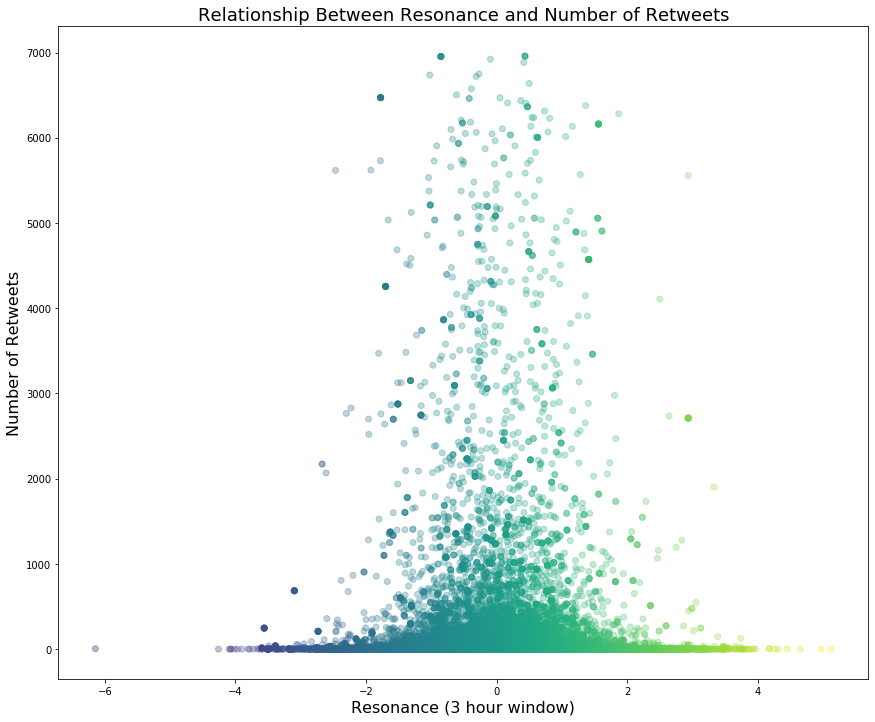

In [475]:
#%% create a histogram of ratio followers to friends

#plt.figure( figsize=(15,12))
#plt.scatter(tweets[tweets['retweet_count']<7000]['res_20min'],
            #tweets[tweets['retweet_count']<7000]['retweet_count'],
            #c=tweets[tweets['retweet_count']<7000]['res_20min'],
            #alpha=0.3)
#plt.xlabel('Resonance (3 hour window)',
           #fontsize=16)
#plt.ylabel('Number of Retweets',
           #fontsize=16)
#plt.title('Relationship Between Resonance and Number of Retweets',
          #fontsize=18)
#plt.subplots_adjust(left=0.15)
#plt.savefig('follower_friend_ratio_sub10.png', format = 'png', bbox_inches='tight')
